In [1]:
from drugSite_scrapers3 import drug, review

In [35]:
import sys, pickle
from time import time

import pandas as pd 
from itertools import islice
import re
# from StringIO import StringIO

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl



# from oc_db_fxns import build_oc_station_db, make_arrays, min_max_print, oc_data_2df
# from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

In [ ]:
# from sklearn import cluster, datasets, metrics
# from sklearn.metrics import euclidean_distances
# from sklearn.neighbors import kneighbors_graph
# from sklearn.preprocessing import StandardScaler
# from oc_clustering_fxns import build_cluster_data, test_clustering

from numpy.random import uniform, seed
from matplotlib.mlab import griddata
# from mpl_toolkits.basemap import shiftgrid
from numpy import linspace
from numpy import meshgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from matplotlib.ticker import MaxNLocator
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.basemap import shiftgrid
# from numpy import linspace
# from numpy import meshgrid
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [27]:
from sklearn import cluster, datasets, metrics
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
# from oc_clustering_fxns import build_cluster_data, test_clustering

In [89]:
class drug_dataset:
    
    def __init__(self, _one_drug):
        self.data, self.target = self.filter_set_data(_one_drug)
#         self.target = self.set_target(_one_drug)
        self.target_names = self.set_target_names()
        
    def set_data(self, _one_drug):
        _data = []
        for rev in _one_drug.reviews:
            _data.append(rev.comment)
        return _data
           
    def set_target(self, _one_drug):
        _targets = []
        abbrev = 'ddc'
        if abbrev == 'ddc':
            for rev in _one_drug.reviews:
                _targets.append(rev.genRating)
        elif _one_drug.abbrev == 'wmd':
            for rev in _one_drug.reviews:
                _targets.append(rev.satisfaction)
        return _targets
    
    def filter_set_data(self, _one_drug):
        temp_data = self.set_data(_one_drug)
        temp_targets = self.set_target(_one_drug)
        
        data = []
        targets = []
        if len(temp_data) == len(temp_targets):
            for ik in range(len(temp_data)):
                if temp_targets[ik] != None:
                    targets.append(int(temp_targets[ik]))
                    data.append(temp_data[ik])
        else:
            print('help!')
        return data, targets
        

    def set_target_names(self):
        return list(set(self.target))
            
        

In [3]:
mini_drug_list = pickle.load(open('drug_list_ddc_mini.p', 'rb'))

In [4]:
one_drug = mini_drug_list[0]

In [90]:
dataset = drug_dataset(one_drug)

In [83]:
clean = [(dataset.target[ik], dataset.data[ik]) for ik in range(len(dataset.target[ik])) if dataset.target[ik] != None]

NameError: name 'ik' is not defined

In [98]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = list(set(labels))
print(type(true_k[-1]))
true_k = np.unique(labels).shape[0]

426 documents
10 categories

<class 'int'>


In [99]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5, max_features=3000,
                                 min_df=2, stop_words='english')

Extracting features from the training dataset using a sparse vectorizer


In [100]:
X = vectorizer.fit_transform(dataset.data)

In [101]:
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

done in 0.810091s
n_samples: 426, n_features: 1338



In [102]:
n_components = 100

In [103]:
if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

Performing dimensionality reduction using LSA
done in 0.200173s
Explained variance of the SVD step: 50%



In [104]:
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)#, verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))


print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.035s

Homogeneity: 0.064
Completeness: 0.059
V-measure: 0.062
Adjusted Rand-Index: 0.019
Silhouette Coefficient: 0.014



In [108]:
if hasattr(km, 'labels_'):
                y_pred = km.labels_.astype(np.int)
else:
                y_pred = km.predict(X)

y_true = labels

In [120]:
print([ik for ik in range(10)].remove(2))

None


In [124]:
def non_picks(pick_id):
    ids = [ik for ik in range(10)]
    ids.remove(pick_id)
    return ids

In [183]:
y_pred = [pred-1 for pred in y_pred]
print(set(y_pred))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [196]:
set(y_true)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [235]:
def filter_count_scores(pick, _y_pred, _y_true):
    filtered_pred = []
    filtered_true = []
    for ik, score in enumerate(_y_pred):
        if score == pick:
            filtered_pred.append(_y_pred[ik])
            filtered_true.append(_y_true[ik])
            
    c = Counter(filtered_true)
    counts_ls = []
    for ik in np.arange(1,11):
        if ik in c.keys():
            counts_ls.append(c[ik])
        else:
            counts_ls.append(0)
    return counts_ls

In [144]:

from collections import Counter

def get_counts(preds):
    c = Counter(preds)
    counts_ls = []
    for ik in range(10):
        counts_ls.append(c[ik])
    return counts_ls


In [199]:
c.keys()

dict_keys([6, 8, 3, 2, 9, 5, 1, 7, 0, 4])

In [ ]:
fig, ax1 = plt.subplots(figsize=figSize, facecolor='w')

N = 10
men_means = (20, 35, 30, 35, 27)
men_std = (2, 3, 4, 1, 2)

ind = np.arange(10)  # the x locations for the groups
width = 0.15       # the width of the bars

rects1 = ax1.bar(ind, men_means, width, color='r', yerr=men_std)

women_means = (25, 32, 34, 20, 25)
women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

In [246]:
# x, y, feat_data, basemap, xLab, yLab, latLon_params = amassData(df3_sub, in_var_names, sliceType, depth = Depth)
N_CLUSTERS = 10

# preds_dict, cluster_fig_SPO = test_clustering2( x, y, feat_data, xLab, yLab, N_CLUSTERS, latLon_params, Map = basemap)

In [242]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib import gridspec

In [256]:
ith_cluster_silhouette_values = sample_silhouette_values[np.array(y_pred) == 1]
ith_cluster_silhouette_values

array([ 0.00822773,  0.02220491,  0.02136581, -0.00818972,  0.00147621,
       -0.00851373,  0.00781686, -0.00790309,  0.01797667, -0.00651593,
        0.03163023, -0.00781905,  0.0129124 , -0.01461684, -0.00196482,
        0.00521795,  0.03969464,  0.08520441,  0.0237253 ,  0.01380322,
        0.01242661, -0.00795691,  0.00375767,  0.00470757,  0.00569038,
        0.00385821, -0.00228763, -0.00597313,  0.01509909,  0.01472551,
        0.01118604, -0.00415795,  0.0207867 , -0.00310756, -0.01758801,
        0.0173012 ,  0.01560504,  0.03159307,  0.00084293, -0.00505805,
        0.00390862, -0.00816501, -0.00905926, -0.0074505 ,  0.01642008,
        0.00699829,  0.00791742, -0.00436861,  0.01126201,  0.01905268])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

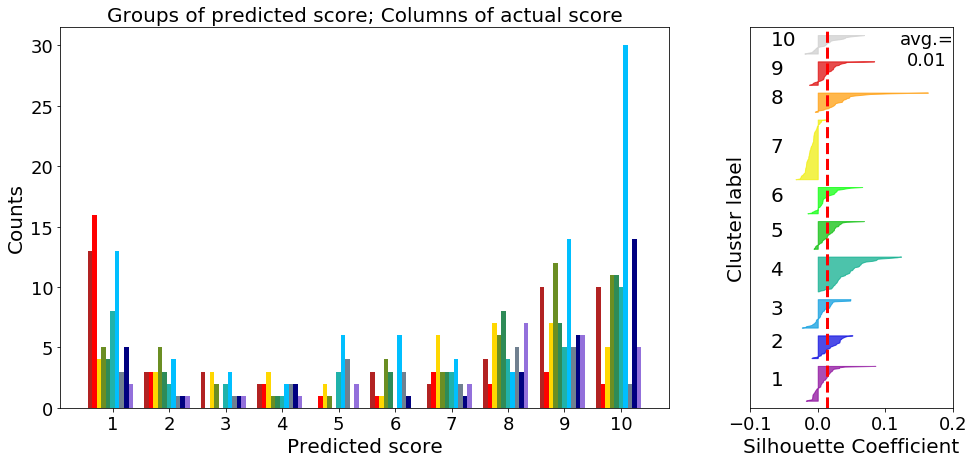

In [270]:
figSize = (16, 7)
title_sz = 27
axis_sz = 20
tick_sz = 18
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figSize, facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

score = metrics.silhouette_score(X, y_pred, metric='euclidean')

ax2 = plt.subplot(gs[1])
ax2.set_xlim([-0.1, .2])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax2.set_ylim([0, len(X) + (N_CLUSTERS + 1) * 10])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, y_pred)

y_lower = 10
y_pred = np.array(y_pred)

for i in range(1,1+N_CLUSTERS):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / N_CLUSTERS)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.07, y_lower + 0.45 * size_cluster_i, str(i), size=axis_sz)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax2.text(.87, .90,'avg.=\n'+ '%.2f' % score, size=tick_sz, transform=plt.gca().transAxes,
    horizontalalignment='center')

#ax2.set_title("The silhouette plot for the various clusters.")
ax2.set_xlabel("Silhouette Coefficient", fontsize=axis_sz)
ax2.set_ylabel("Cluster label",fontsize=axis_sz)

# The vertical line for average silhoutte score of all the values
ax2.axvline(x=score, color="red", linestyle="--", linewidth=3)

ax2.set_yticks([])  # Clear the yaxis labels / ticks
#ax2.set_xticks([ 0, .3, .6, .9])

xtickNames = ax2.get_xticklabels()
ytickNames = ax2.get_yticklabels()

plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
plt.setp(xtickNames, rotation=0, fontsize=tick_sz)


ax1 = plt.subplot(gs[0])
N = 10
ind = np.arange(1,11)  # the x locations for the groups
width = 0.08       # the width of the bars
colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']

for score in np.arange(1,11):
    cts = filter_count_scores(score, y_pred, y_true)
    rects = ax1.bar((ind-5*width)+(score-1)*width, cts, width, color=colors[score-1])

plt.xticks([ik-.15*5 for ik in np.arange(1,11)],  np.arange(1,11), rotation='vertical')
plt.xticks([ik for ik in np.arange(1,11)], np.arange(1,11), rotation='vertical')

ax1.set_xlabel('Predicted score', fontsize=axis_sz)
ax1.set_ylabel('Counts', fontsize=axis_sz)

plt.title('Groups of predicted score; Columns of actual score', fontsize=axis_sz) 

xtickNames = ax1.get_xticklabels()
ytickNames = ax1.get_yticklabels()

plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
plt.setp(xtickNames, rotation=0, fontsize=tick_sz)

Text(0.5,1,'groups of predicted score, columns of actual score')

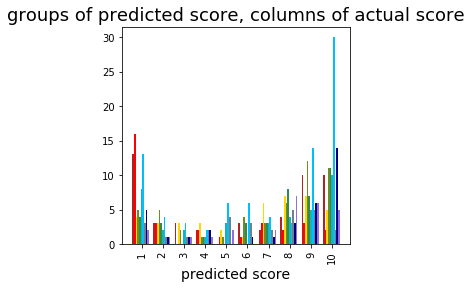

In [262]:

# fig, ax1 = plt.subplots(figsize = (22, 4), facecolor='w')

ax1 = plt.subplot(gs[0])
N = 10
ind = np.arange(1,11)  # the x locations for the groups
width = 0.08       # the width of the bars
colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']

for score in np.arange(1,11):
    cts = filter_count_scores(score, y_pred, y_true)
    rects = ax1.bar((ind-5*width)+(score-1)*width, cts, width, color=colors[score-1])

plt.xticks([ik-.15*5 for ik in np.arange(1,11)],  np.arange(1,11), rotation='vertical')
plt.xticks([ik for ik in np.arange(1,11)], np.arange(1,11), rotation='vertical')

ax1.set_xlabel('predicted score', fontsize=14)
plt.title('groups of predicted score, columns of actual score', fontsize=18)      # ncol=4,  borderaxespad=0.,prop={'size':14-2})


In [ ]:
#with silhouette plot

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib import gridspec

def test_clustering_wSil(_x, _y, _data, _xLab, _yLab, N_CLUSTERS, _latLon_params, **kwargs):
    pred_dict = {}
    np.random.seed(0)

    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)
    
    plot_num = 1
    for i_dataset, dataset in enumerate([_data]):
        X = dataset
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(X, n_neighbors=10)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # Compute distances
        distances = euclidean_distances(X)

        # create clustering estimators
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=N_CLUSTERS)
        ward = cluster.AgglomerativeClustering(n_clusters=N_CLUSTERS,
                        linkage='ward', connectivity=connectivity)
        spectral = cluster.SpectralClustering(n_clusters=N_CLUSTERS,
                                              eigen_solver='arpack',
                                              affinity="nearest_neighbors")
        dbscan = cluster.DBSCAN(eps=.2)
        affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                           preference=-200)

        average_linkage = cluster.AgglomerativeClustering(linkage="average",
                                affinity="cityblock", n_clusters=N_CLUSTERS,
                                connectivity=connectivity)
        #brc = cluster.Birch(threshold = .5, branching_factor = 50, n_clusters = N_CLUSTERS)
        
        alg_list = [('MiniBatchKMeans', two_means)]#,
                    #('Birch', brc)]
                    #('DBSCAN', dbscan),
                    #('AffinityPropagation', affinity_propagation)]
                    #('MeanShift', ms)]
                    #,
                    #('SpectralClustering', spectral),
                    #('Ward', ward)]:
                    #('AgglomerativeClustering', average_linkage),
                    #('DBSCAN', dbscan)
                    #]:
        if kwargs['Map']:
            figSize = (14, 10)
        else:
            figSize = (16, 7)
        fig, (ax1, ax2) = plt.subplots(nrows=len(alg_list), ncols=2, figsize=figSize, facecolor='w')
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
        for name, algorithm in alg_list:
            # predict cluster memberships
            t0 = time.time()
            algorithm.fit(X)
            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            score = metrics.silhouette_score(X, y_pred, metric='euclidean')
            
            ax2 = plt.subplot(gs[1])
            ax2.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax2.set_ylim([0, len(X) + (N_CLUSTERS + 1) * 10])

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, y_pred)

            y_lower = 10
            for i in range(N_CLUSTERS):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[y_pred == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.spectral(float(i) / N_CLUSTERS)
                ax2.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax2.text(-0.07, y_lower + 0.45 * size_cluster_i, str(i), size=axis_sz)

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples
            
            ax2.text(.87, .90,'avg.=\n'+ '%.2f' % score, size=tick_sz, transform=plt.gca().transAxes,
                horizontalalignment='center')
            
            #ax2.set_title("The silhouette plot for the various clusters.")
            ax2.set_xlabel("Silhouette Coefficient", fontsize=axis_sz)
            ax2.set_ylabel("Cluster label",fontsize=axis_sz)

            # The vertical line for average silhoutte score of all the values
            ax2.axvline(x=score, color="red", linestyle="--", linewidth=3)

            ax2.set_yticks([])  # Clear the yaxis labels / ticks
            ax2.set_xticks([ 0, .3, .6, .9])

            xtickNames = ax2.get_xticklabels()
            ytickNames = ax2.get_yticklabels()

            plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
            plt.setp(xtickNames, rotation=0, fontsize=tick_sz)
            
            # plot
            _colors = cm.spectral(y_pred.astype(float) / N_CLUSTERS)
            #_colors = colors[y_pred].tolist()
            #color_preds = [_colors[ik]+'o' for ik in xrange(len(_colors))]
            
            if kwargs['Map']:
                ax1 = plt.subplot(gs[0])
                #ax1 = plt.subplot(1, len(alg_list), 1)
                
                _basemap = kwargs['Map']
                _basemap.ax = ax1
                _basemap.drawcoastlines(color='k')
                _basemap.drawcountries()
                _basemap.fillcontinents(lake_color='b',color = 'gray')
                _basemap.drawmapboundary(linewidth=3)
                _basemap.drawmeridians(np.arange(0, 360, 30))
                _basemap.drawparallels(np.arange(-90, 90, 30))

                x,y = _basemap(_x, _y)
                #for im in xrange(len(x)):
                #    _basemap.plot(x[im], y[im], color = _colors[im], marker = 'o', markersize=5, alpha = .3)    
                _basemap.scatter(x, y, c = _colors, marker = 'o', s=30, alpha = .2)
                #pred_dict[name] = [_x, _y, colors[y_pred].tolist()] 
                #x_tics_loc = 
                #ax1.set_xticks([-30, 0, 30, 60])
                #ax1.set_yticks([-60, -30, 0, 30])
                
            # build plot here of as per discussion on Saturday
            else:
                
#                 fig, ax1 = plt.subplots(figsize = (22, 4), facecolor='w')

                N = 10
                ind = np.arange(1,11)  # the x locations for the groups
                width = 0.08       # the width of the bars
                colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']

                for score in np.arange(1,11):
                    cts = filter_count_scores(score, y_pred, y_true)
                    rects = ax1.bar((ind-5*width)+(score-1)*width, cts, width, color=colors[score-1])

                plt.xticks([ik-.15*5 for ik in np.arange(1,11)],  np.arange(1,11), rotation='vertical')
                plt.xticks([ik for ik in np.arange(1,11)], np.arange(1,11), rotation='vertical')

                ax1.set_xlabel('predicted score', fontsize=14)
                plt.title('groups of predicted score, columns of actual score', fontsize=18) 
                
                
                ax1.set_xlim(min(_x), max(_x))
                ax1.set_ylim(min(_y)-100, max(_y)+200)
#                 ax1.invert_yaxis()
                
#                 axin = inset_axes(ax1, width="35%", height="35%", loc=4)
#                 inmap = Basemap(projection='ortho', lon_0=np.mean(_latLon_params[0]), lat_0=0,
#                     ax=axin, anchor='NE')
#                 inmap.fillcontinents()
#                 inmap.drawcoastlines(color='k')
#                 inmap.plot(_latLon_params[0], _latLon_params[1], '-k', linewidth=2 , latlon=True)  

                # set tick size
                xtickNames = ax1.get_xticklabels()
                ytickNames = ax1.get_yticklabels()

                plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
                plt.setp(xtickNames, rotation=0, fontsize=tick_sz)
                
            # label axes    
            ax1.set_ylabel(_yLab, fontsize=axis_sz)
            ax1.set_xlabel(_xLab, fontsize=axis_sz)
            
            # title with model name and score
            if i_dataset == 0:
                ax1.set_title(name, size=title_sz)
            
            # algorithm fit time in bottome right corner
            ax1.text(.99, .01,('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=12,
                horizontalalignment='right')
            
            plot_num += 1   
            
    plt.tight_layout(pad=0.4, w_pad=1., h_pad=1.)    
    plt.show()
    return pred_dict, fig    
